##1. Load Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("phileinsophos/predict-loan-amount-data")

print("Path to dataset files:", path)

100%|██████████| 2.44M/2.44M [00:00<00:00, 70.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/phileinsophos/predict-loan-amount-data/versions/1


In [ ]:
import os

# List all files in the dataset folder
print(os.listdir(path))


['test.csv', 'train.csv']


In [ ]:
import pandas as pd

df = pd.read_csv(os.path.join(path, 'train.csv'))
print(df.head())


  Customer ID               Name Gender  Age  Income (USD) Income Stability  \
0     C-36995   Frederica Shealy      F   56       1933.05              Low   
1     C-33999  America Calderone      M   32       4952.91              Low   
2      C-3770      Rosetta Verne      F   65        988.19             High   
3     C-26480         Zoe Chitty      F   65           NaN             High   
4     C-23459       Afton Venema      F   31       2614.77              Low   

  Profession     Type of Employment    Location  Loan Amount Request (USD)  \
0    Working            Sales staff  Semi-Urban                   72809.58   
1    Working                    NaN  Semi-Urban                   46837.47   
2  Pensioner                    NaN  Semi-Urban                   45593.04   
3  Pensioner                    NaN       Rural                   80057.92   
4    Working  High skill tech staff  Semi-Urban                  113858.89   

   ...  Credit Score No. of Defaults Has Active Credit C

In [ ]:
print(df.head(), df.shape)

  Customer ID               Name Gender  Age  Income (USD) Income Stability  \
0     C-36995   Frederica Shealy      F   56       1933.05              Low   
1     C-33999  America Calderone      M   32       4952.91              Low   
2      C-3770      Rosetta Verne      F   65        988.19             High   
3     C-26480         Zoe Chitty      F   65           NaN             High   
4     C-23459       Afton Venema      F   31       2614.77              Low   

  Profession     Type of Employment    Location  Loan Amount Request (USD)  \
0    Working            Sales staff  Semi-Urban                   72809.58   
1    Working                    NaN  Semi-Urban                   46837.47   
2  Pensioner                    NaN  Semi-Urban                   45593.04   
3  Pensioner                    NaN       Rural                   80057.92   
4    Working  High skill tech staff  Semi-Urban                  113858.89   

   ...  Credit Score No. of Defaults Has Active Credit C

## 2. EDA

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:

#Drop irrelevant columns
df.drop(columns=['Customer ID', 'Name', 'Property ID'], inplace=True)


In [ ]:
print(df.isnull().sum().sum())


25062


## Handling Missing Values

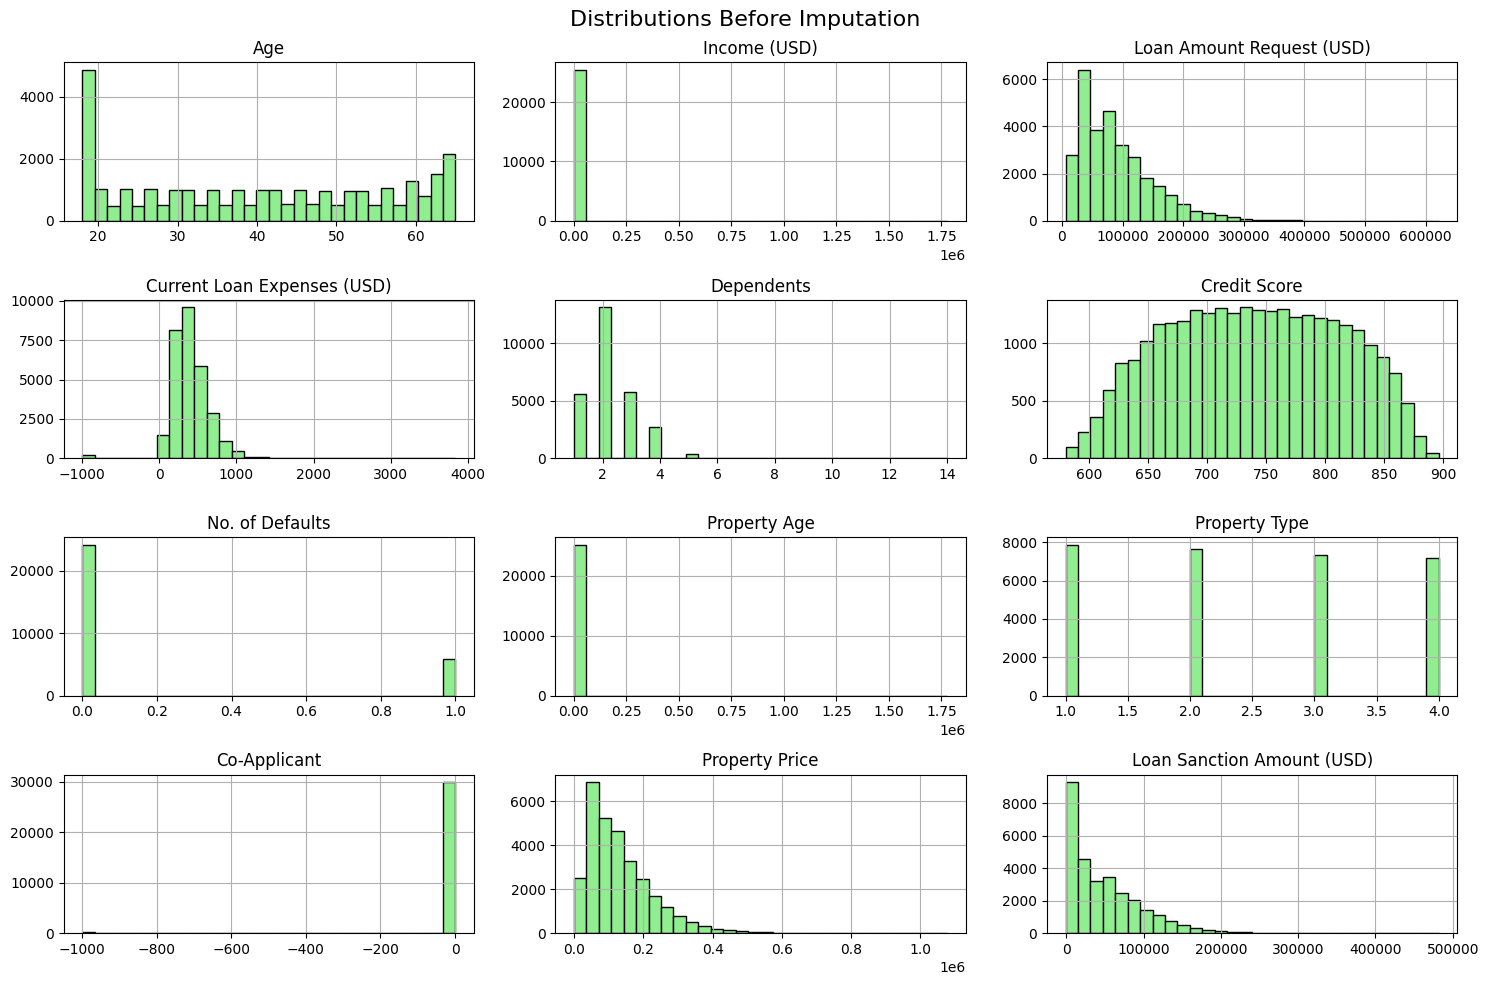

Income (USD): filled with MEDIAN
Current Loan Expenses (USD): filled with MEAN
Dependents: filled with MEDIAN
Credit Score: filled with MEAN
Property Age: filled with MEDIAN
Loan Sanction Amount (USD): filled with MEDIAN
Gender: filled with MODE
Income Stability: filled with MODE
Type of Employment: filled with MODE
Has Active Credit Card: filled with MODE
Property Location: filled with MODE


/tmp/ipython-input-3778061486.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-3778061486.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [ ]:
# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

# Histograms before imputation
df.hist(bins=30, figsize=(15, 10), color='lightgreen', edgecolor='black')
plt.suptitle("Distributions Before Imputation", fontsize=16)
plt.tight_layout()
plt.show()

# Imputation Strategy: Smart based on distribution
for col in num_cols:
    if df[col].isnull().sum() > 0:
        skewness = df[col].skew()
        if abs(skewness) < 0.5:
            # Symmetric → use mean
            df[col].fillna(df[col].mean(), inplace=True)
            print(f"{col}: filled with MEAN")
        else:
            # Skewed → use median
            df[col].fillna(df[col].median(), inplace=True)
            print(f"{col}: filled with MEDIAN")

for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"{col}: filled with MODE")


In [ ]:
print("Total missing values after imputation:", df.isnull().sum().sum())


Total missing values after imputation: 0


In [ ]:
# We'll use IQR for skewed features, Z-score for symmetric features

from scipy import stats

def remove_outliers(df, threshold=3):
    df_clean = df.copy()
    num_cols = df_clean.select_dtypes(include=np.number).columns

    for col in num_cols:
        skewness = df_clean[col].skew()
        if abs(skewness) < 0.5:
            # Symmetric → Z-score
            z = np.abs(stats.zscore(df_clean[col]))
            df_clean = df_clean[z < threshold]
            print(f"{col}: Removed outliers using Z-score")
        else:
            # Skewed → IQR
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
            print(f"{col}: Removed outliers using IQR")

    return df_clean

df_clean = remove_outliers(df)
print("Shape after outlier removal:", df_clean.shape)


Age: Removed outliers using Z-score
Income (USD): Removed outliers using IQR
Loan Amount Request (USD): Removed outliers using IQR
Current Loan Expenses (USD): Removed outliers using IQR
Dependents: Removed outliers using IQR
Credit Score: Removed outliers using Z-score
No. of Defaults: Removed outliers using IQR
Property Age: Removed outliers using IQR
Property Type: Removed outliers using Z-score
Co-Applicant: Removed outliers using IQR
Property Price: Removed outliers using IQR
Loan Sanction Amount (USD): Removed outliers using IQR
Shape after outlier removal: (16968, 21)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Separate features and target
X = df_clean.drop('Loan Sanction Amount (USD)', axis=1)
y = df_clean['Loan Sanction Amount (USD)']


# Make a copy of the original feature set
X_encoded = X.copy()

# Automatically detect object (categorical) columns
cat_cols = X_encoded.select_dtypes(include=['object']).columns

label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le  # Store encoder if you want to inverse transform later
    print(f"Encoded: {col}")


Encoded: Gender
Encoded: Income Stability
Encoded: Profession
Encoded: Type of Employment
Encoded: Location
Encoded: Expense Type 1
Encoded: Expense Type 2
Encoded: Has Active Credit Card
Encoded: Property Location


In [ ]:
print(X_encoded.dtypes)


Gender                           int64
Age                              int64
Income (USD)                   float64
Income Stability                 int64
Profession                       int64
Type of Employment               int64
Location                         int64
Loan Amount Request (USD)      float64
Current Loan Expenses (USD)    float64
Expense Type 1                   int64
Expense Type 2                   int64
Dependents                     float64
Credit Score                   float64
No. of Defaults                  int64
Has Active Credit Card           int64
Property Age                   float64
Property Type                    int64
Property Location                int64
Co-Applicant                     int64
Property Price                 float64
dtype: object


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


###Model Building

In [ ]:
# Train-Validation-Test split
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


In [ ]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear']
}

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_svr = grid_search.best_estimator_
print("Best C:", grid_search.best_params_['C'])

# Evaluate on validation set
y_val_pred = best_svr.predict(X_val)
print("\n--- SVR - Validation ---")
print("MAE:", mean_absolute_error(y_val, y_val_pred))
print("MSE:", mean_squared_error(y_val, y_val_pred))
print("R² Score:", r2_score(y_val, y_val_pred))

# Combine train + val to retrain
X_combined = np.vstack((X_train, X_val))
y_combined = np.concatenate([y_train, y_val])
final_svr = SVR(C=grid_search.best_params_['C'], kernel='linear')
final_svr.fit(X_combined, y_combined)

# Predict on test
y_test_pred = final_svr.predict(X_test)
print("\n--- SVR - Test ---")
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("MSE:", mean_squared_error(y_test, y_test_pred))
print("R² Score:", r2_score(y_test, y_test_pred))

Best C: 10

--- SVR - Validation ---
MAE: 13184.876235722902
MSE: 638212807.395315
R² Score: 0.5178082039753726

--- SVR - Test ---
MAE: 12853.775051577637
MSE: 637794647.0973693
R² Score: 0.5271051009288765
